In [23]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from skimage.feature import hog
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

In [24]:
# Download the dataset
path = kagglehub.dataset_download("karakaggle/kaggle-cat-vs-dog-dataset")
print("Path to dataset files:", path)

# Define paths to Cat and Dog folders
cat_path = os.path.join(path, "kagglecatsanddogs_3367a", "PetImages", "Cat")
dog_path = os.path.join(path, "kagglecatsanddogs_3367a", "PetImages", "Dog")

# Verify the paths exist
print("Cat folder exists:", os.path.exists(cat_path))
print("Dog folder exists:", os.path.exists(dog_path))

Path to dataset files: /kaggle/input/kaggle-cat-vs-dog-dataset
Cat folder exists: True
Dog folder exists: True


In [25]:
# Function to load and preprocess images
def load_and_preprocess_images(folder_path, label, img_size=(64, 64), max_images=1000):
    images = []
    labels = []
    for file in os.listdir(folder_path):
        if file.endswith('.jpg'):
            img_path = os.path.join(folder_path, file)
            try:
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Load in grayscale
                if img is None:  # Skip if image fails to load
                    continue
                img = cv2.resize(img, img_size)  # Resize to 64x64
                img = img.flatten()  # Flatten to 1D array (64*64 = 4096 features)
                images.append(img)
                labels.append(label)
            except Exception as e:
                print(f"Error loading {img_path}: {e}")
        if len(images) >= max_images:  # Limit to max_images
            break
    return images, labels

# Load cat and dog images
cat_images, cat_labels = load_and_preprocess_images(cat_path, label=0, max_images=1000)
dog_images, dog_labels = load_and_preprocess_images(dog_path, label=1, max_images=1000)

# Combine the data
X = np.array(cat_images + dog_images)
y = np.array(cat_labels + dog_labels)

print("Shape of feature matrix X:", X.shape)
print("Shape of label vector y:", y.shape)

Shape of feature matrix X: (2000, 4096)
Shape of label vector y: (2000,)


In [26]:
def extract_hog_features(images, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    hog_features = []
    for img in images:
        # Reshape the flattened image back to 64x64 for HOG
        img_reshaped = img.reshape(64, 64)
        # Extract HOG features
        features = hog(img_reshaped, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block)
        hog_features.append(features)
    return np.array(hog_features)

In [27]:
# Extract HOG features
X_hog = extract_hog_features(X)
print("HOG features shape:", X_hog.shape)

# Apply PCA to reduce dimensionality
pca = PCA(n_components=100, random_state=42)
X_hog_pca = pca.fit_transform(X_hog)
print("Shape after PCA:", X_hog_pca.shape)

HOG features shape: (2000, 1764)
Shape after PCA: (2000, 100)


In [28]:
# Split the data into training and test sets
X_train_hog, X_test_hog, y_train, y_test = train_test_split(X_hog_pca, y, test_size=0.2, random_state=42)

In [29]:
# Define parameter grid for SVM
param_grid = {
    'C': [0.1, 1, 10],
    'gamma': ['scale', 'auto', 0.01, 0.1]
}

# Initialize SVM with RBF kernel
svm_rbf = SVC(kernel='rbf', random_state=42)

# Perform grid search
grid_search = GridSearchCV(svm_rbf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train_hog, y_train)

GridSearchCV(cv=5, estimator=SVC(random_state=42), n_jobs=-1,
             param_grid={'C': [0.1, 1, 10],
                         'gamma': ['scale', 'auto', 0.01, 0.1]},
             scoring='accuracy')

In [30]:
# Get the best model
best_svm = grid_search.best_estimator_
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation accuracy:", grid_search.best_score_)

# Evaluate on test set
y_pred_best = best_svm.predict(X_test_hog)
accuracy_best = accuracy_score(y_test, y_pred_best)
print("Tuned SVM Accuracy:", accuracy_best)
print("\nClassification Report:\n", classification_report(y_test, y_pred_best, target_names=['Cat', 'Dog']))

Best parameters: {'C': 10, 'gamma': 'scale'}
Best cross-validation accuracy: 0.715625
Tuned SVM Accuracy: 0.76

Classification Report:
               precision    recall  f1-score   support

         Cat       0.76      0.75      0.76       199
         Dog       0.76      0.77      0.76       201

    accuracy                           0.76       400
   macro avg       0.76      0.76      0.76       400
weighted avg       0.76      0.76      0.76       400



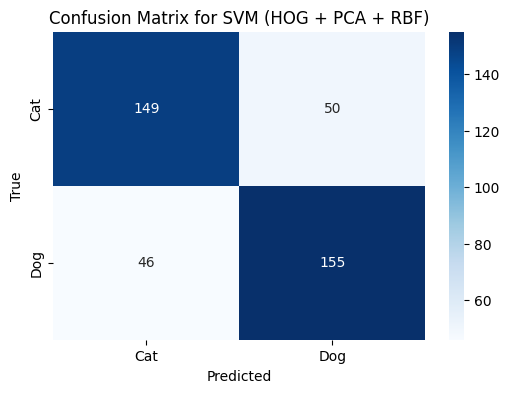

In [31]:
# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Cat', 'Dog'], yticklabels=['Cat', 'Dog'])
plt.title('Confusion Matrix for SVM (HOG + PCA + RBF)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

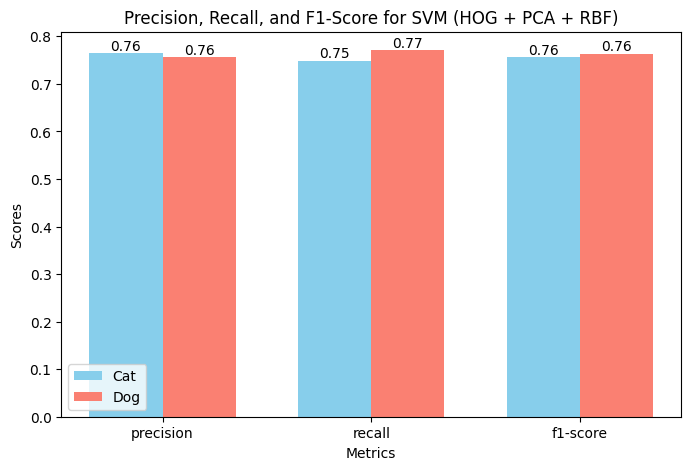

In [32]:
# Extract metrics from classification report
report = classification_report(y_test, y_pred_best, target_names=['Cat', 'Dog'], output_dict=True)

# Prepare data for plotting
metrics = ['precision', 'recall', 'f1-score']
cat_scores = [report['Cat'][metric] for metric in metrics]
dog_scores = [report['Dog'][metric] for metric in metrics]

# Set up the bar plot
x = np.arange(len(metrics))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5))
bars1 = ax.bar(x - width/2, cat_scores, width, label='Cat', color='skyblue')
bars2 = ax.bar(x + width/2, dog_scores, width, label='Dog', color='salmon')

# Add labels and title
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Precision, Recall, and F1-Score for SVM (HOG + PCA + RBF)')
ax.set_xticks(x)
ax.set_xticklabels(metrics)
ax.legend()

# Add value labels on top of bars
for bar in bars1:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')
for bar in bars2:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2, height, f'{height:.2f}', ha='center', va='bottom')

plt.show()